# Showcasing the results
1. Estimation performance
2. Hypothesis testing performance

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import seaborn as sns
import os

In [10]:
f_name = "out/estimate/hsq-0.1-pcausal-0.001-cor-0.8-hermodel-mafukb.estimate.json"

with open(f_name) as f:
    data = json.load(f)

    df_plot = pd.DataFrame(
        np.array([d["estimate"] for d in data]),
        columns=[
            "estimated_var_g",
            "estimated_rho",
            "estimated_var_e",
        ],
    )
df_plot["estimated_ratio"] = df_plot["estimated_rho"] / df_plot["estimated_var_g"]

In [12]:
df_plot.mean()

estimated_var_g    0.364650
estimated_rho      0.291070
estimated_var_e    0.918477
estimated_ratio    0.805008
dtype: float64

In [2]:
rls_list = []

for simulate_snpset in ["hm3", "imputed"]:
    for estimate_snpset in ["hm3", "imputed"]:
        for pcausal in [0.01, 0.001, 1.0]:
            for cor in [0.8, 1.0]:
                for hermodel in ["uniform", "gcta", "ldak"]:
                    f_name = (
                        f"out/estimate/snpset-{simulate_snpset}-hsq-0.1-pcausal-{pcausal}-cor-{cor}"
                        + f"-hermodel-{hermodel}.{estimate_snpset}.estimate.json"
                    )
                    if not os.path.exists(f_name):
                        continue
                    with open(f_name) as f:
                        data = json.load(f)

                        df_tmp = pd.DataFrame(
                            np.array([d["estimate"] for d in data]),
                            columns=[
                                "estimated_var_g",
                                "estimated_rho",
                                "estimated_var_e",
                            ],
                        )
                        df_tmp["simulate_snpset"] = simulate_snpset
                        df_tmp["estimate_snpset"] = estimate_snpset
                        df_tmp["cor"] = cor
                        df_tmp["pcausal"] = pcausal
                        df_tmp["hermodel"] = hermodel
                        rls_list.append(df_tmp)

df_plot = pd.concat(rls_list)
df_plot["estimated_ratio"] = df_plot["estimated_rho"] / df_plot["estimated_var_g"]

In [9]:
df_plot[
    (df_plot.simulate_snpset == "imputed") & (df_plot.estimate_snpset == "imputed")
].estimated_ratio

0     0.376885
1     0.866817
2     0.943525
3     1.236227
4     1.101403
5     0.322335
6     1.275245
7     1.038082
8     1.010750
9     0.983567
10    1.260833
11    0.869844
12    1.075764
13    1.169168
14    0.958494
15    0.510689
16    0.493059
17    1.105540
18    0.837866
19    1.412683
20    0.669705
21    1.196692
22    0.646298
23    1.111710
24    1.150330
25    0.868339
26    0.603428
27    1.241951
28    1.264865
29    1.584282
0     1.321439
1     1.521365
2     1.179673
3     1.001213
4     0.736274
5     0.233889
6     1.747107
7     0.803866
8     0.700176
9     1.142922
10    1.284017
11    1.356194
12    0.932536
13    0.699864
14    0.805580
15    0.901972
16    0.281533
17    0.880675
18    0.732684
19    1.373275
20    0.584541
21    1.227060
22    0.762566
23    1.111988
24    0.701931
25    1.162206
26    0.980640
27    0.715222
28    1.230670
29    2.281704
Name: estimated_ratio, dtype: float64

In [29]:
# rls_list = []

# for simulate_snpset in ["hm3", "imputed"]:
#     for estimate_snpset in ["hm3", "imputed"]:
#         for pcausal in [0.005, 0.1, 1.0]:
#             for rho in [0.5, 0.8, 1.0]:
#                 f_name = f"out/estimate/snpset-{simulate_snpset}-varg-1.0-pcausal-{pcausal}-rho-{rho}.{estimate_snpset}.estimate.json"
#                 if not os.path.exists(f_name):
#                     continue
#                 with open(f_name) as f:
#                     data = json.load(f)
#                     df_tmp = pd.DataFrame(
#                         np.array([d["estimate"] for d in data]),
#                         columns=["estimated_var_g", "estimated_rho", "estimated_var_e"],
#                     )
#                     df_tmp["simulate_snpset"] = simulate_snpset
#                     df_tmp["estimate_snpset"] = estimate_snpset
#                     df_tmp["rho"] = rho
#                     df_tmp["pcausal"] = pcausal
#                     rls_list.append(df_tmp)

# df_plot = pd.concat(rls_list)
# df_plot["estimated_ratio"] = df_plot["estimated_rho"] / df_plot["estimated_var_g"]

ValueError: min() arg is an empty sequence

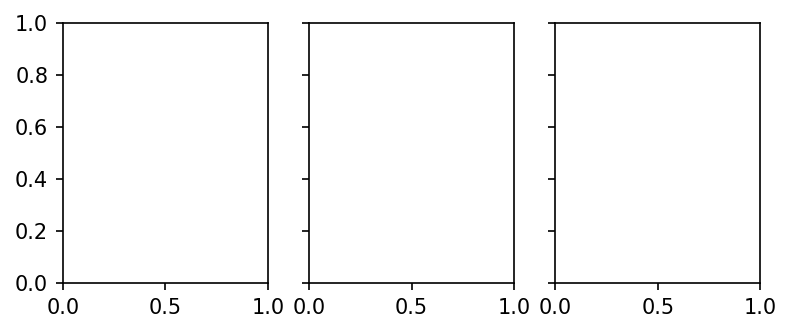

In [4]:
for simulate_snpset, estimate_snpset in [
    ["imputed", "imputed"],
    ["hm3", "hm3"],
    ["imputed", "hm3"],
]:
    fig, axes = plt.subplots(
        figsize=(6, 2.3), dpi=150, sharex=True, sharey=True, ncols=3
    )

    for ax_i, pcausal in enumerate([0.001, 0.01, 1.0]):
        df_tmp = df_plot[
            (df_plot.simulate_snpset == simulate_snpset)
            & (df_plot.estimate_snpset == estimate_snpset)
            & (df_plot.pcausal == pcausal)
        ]
        ax = axes[ax_i]
        sns.pointplot(
            data=df_tmp,
            x="cor",
            y="estimated_ratio",
            hue="hermodel",
            dodge=0.2,
            join=False,
            ax=ax,
            markers=".",
        )

        cor_list = df_plot.cor.unique()

        ax.hlines(
            cor_list,
            np.arange(len(cor_list)) - 0.2,
            np.arange(len(cor_list)) + 0.2,
            color="red",
            ls="--",
            zorder=10,
        )
        ax.set_ylim(0.2, 1.3)
        ax.set_xlabel("Simulated $r_g$")
        ax.set_ylabel("Estimated $r_g$")
        ax.set_title("$p_{causal}$" + f" = {pcausal}")
        if ax_i != 0:
            axes[ax_i].legend([], [], frameon=False)
    fig.suptitle(
        f"Simulation: {simulate_snpset}, Estimation: {estimate_snpset}", y=1.05
    )